# Music Generation

In [85]:
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream, graph
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM

## Dataset Visualization

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x1944739f9a0>>

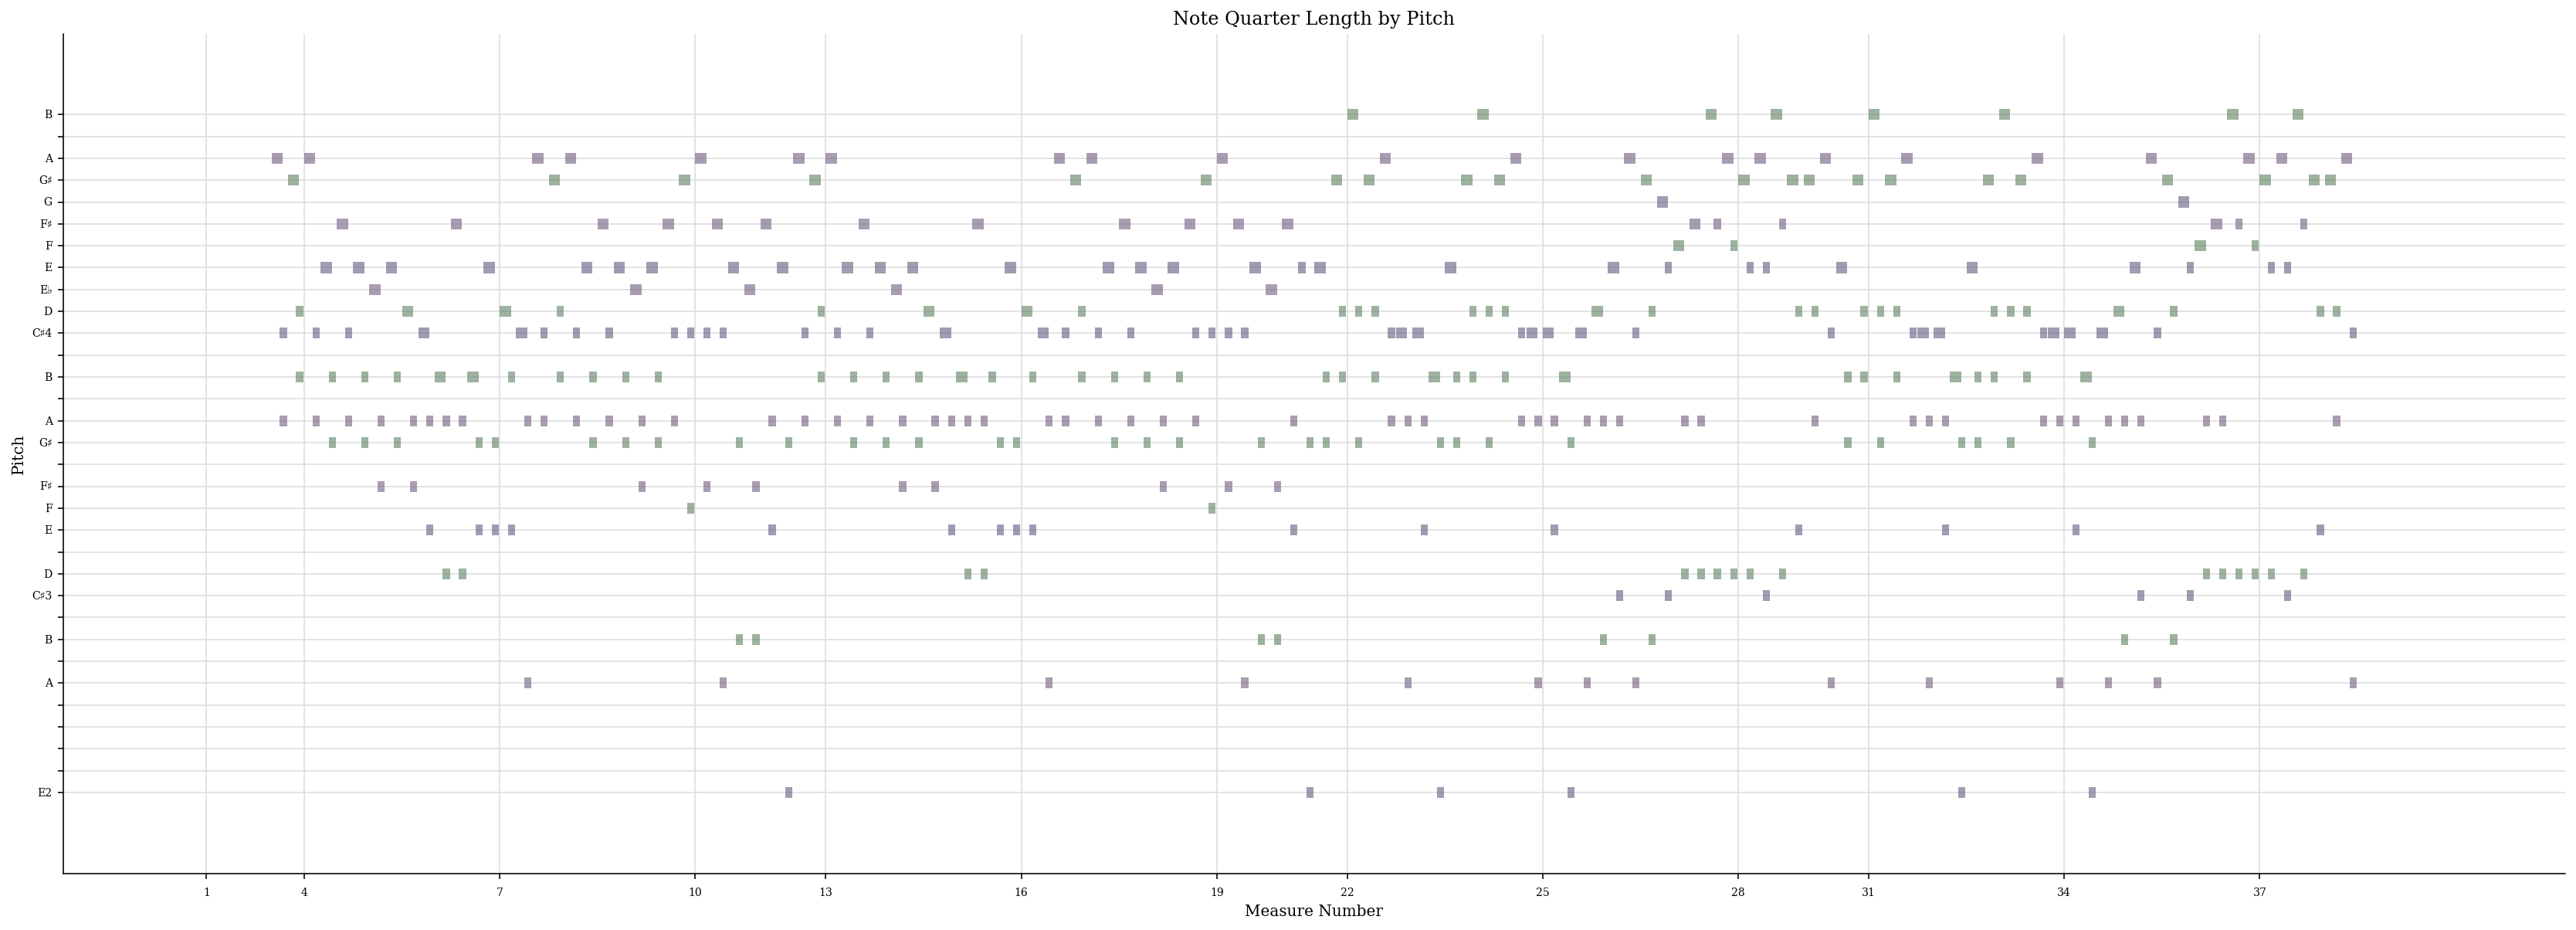

In [86]:
s = converter.parse("datasets\midi_songs2 classical\Study No.3.mid")
s.plot('pianoroll', figureSize=(30,10))


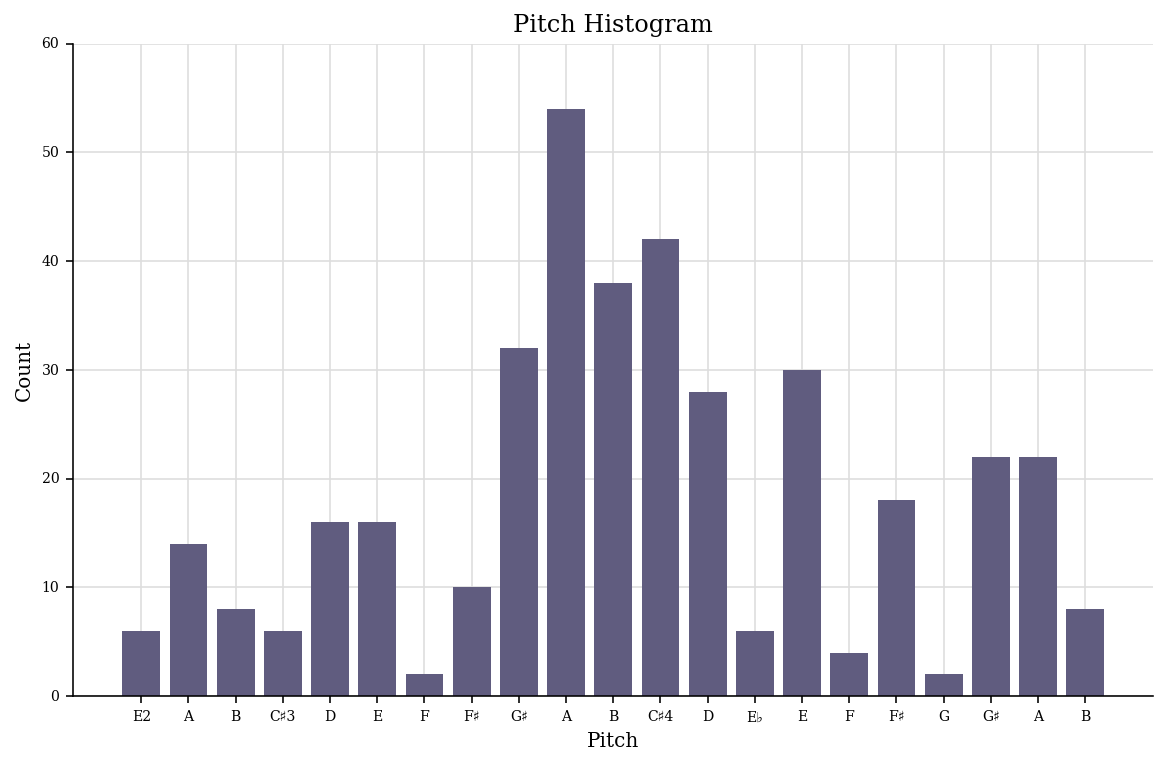

In [87]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x19440dd8a00>>

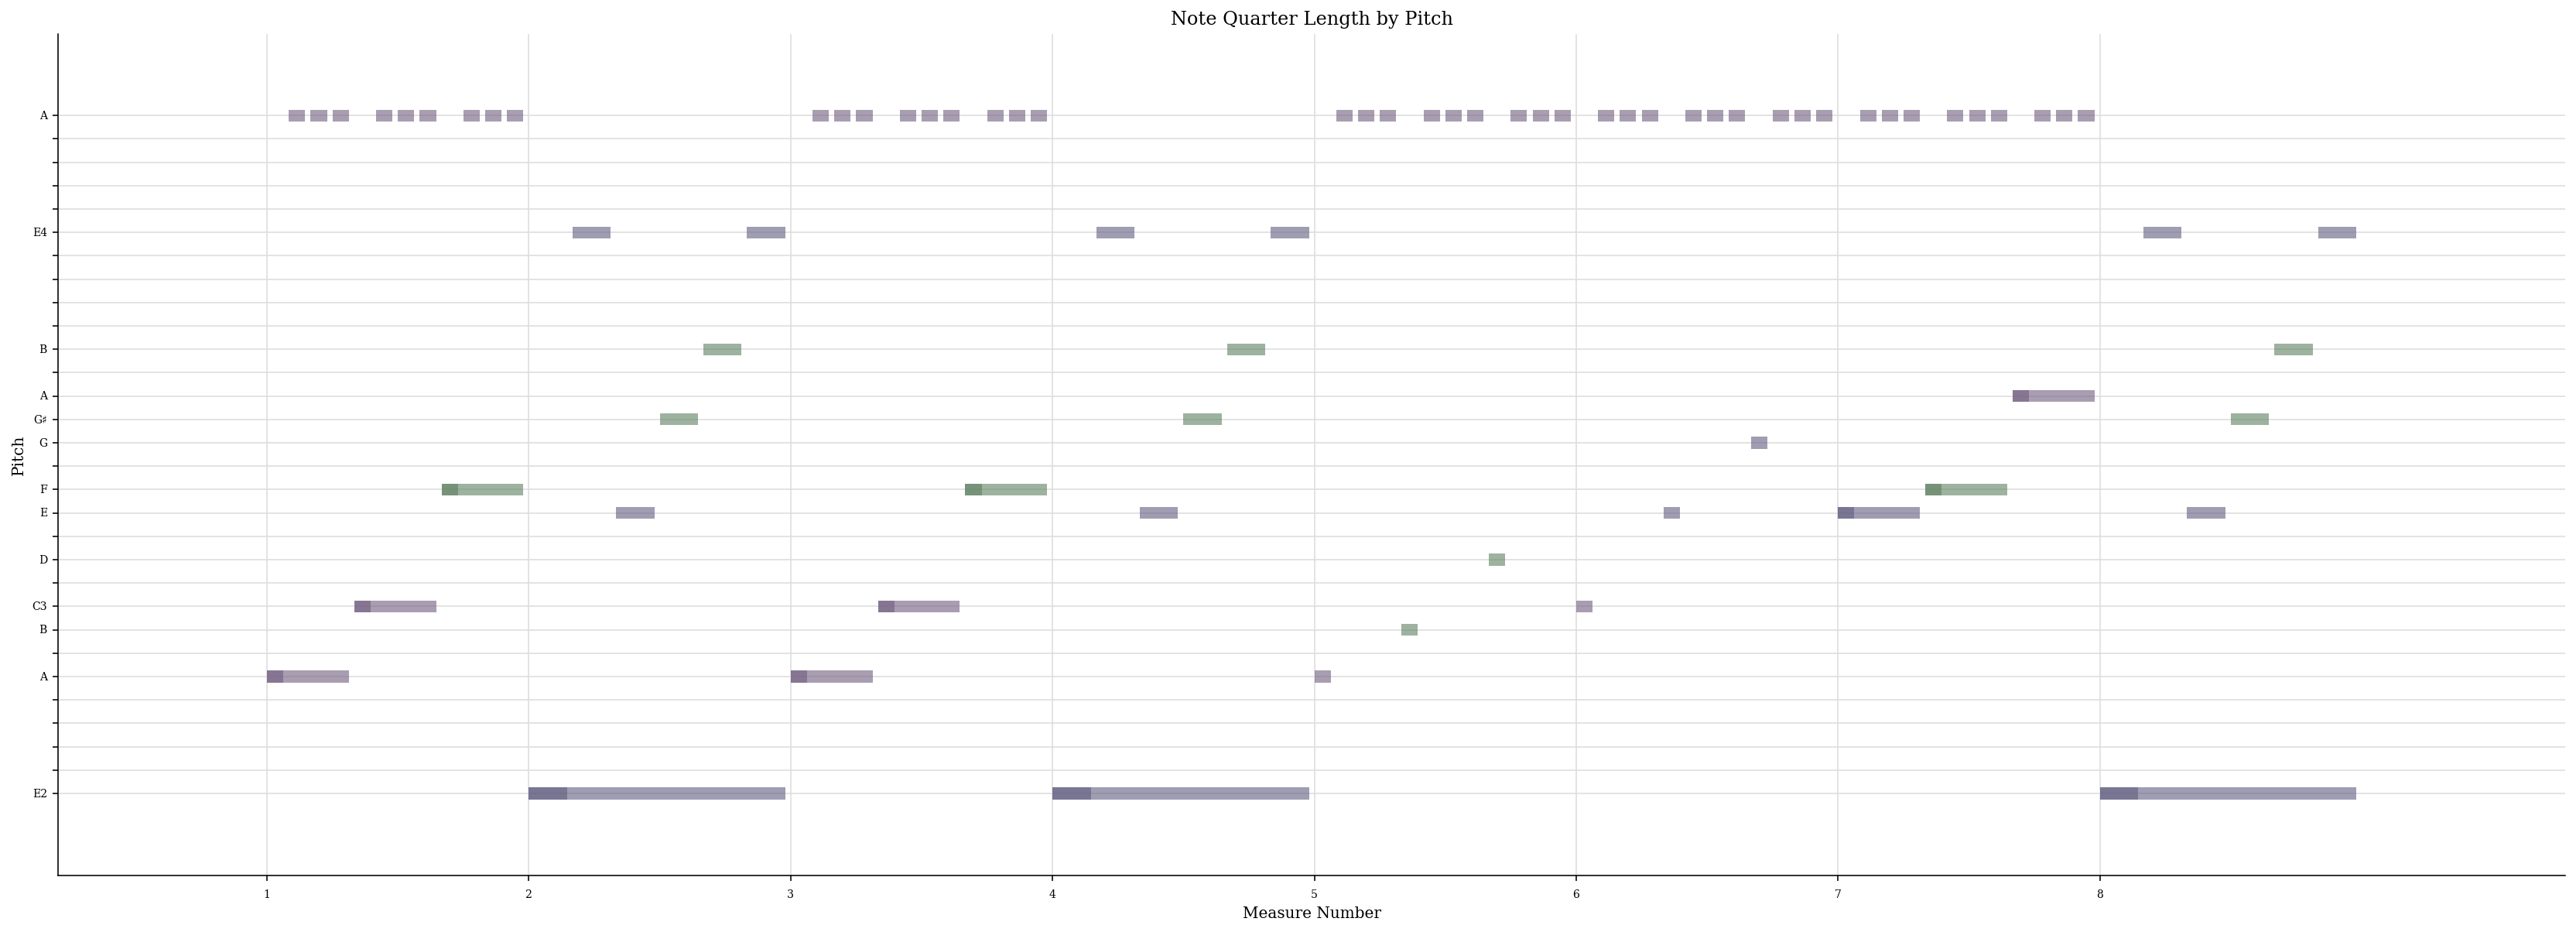

In [88]:
s = converter.parse("datasets\midi_songs2 classical\Tremolo Exercise.mid")
s.plot('pianoroll', figureSize=(30,10))

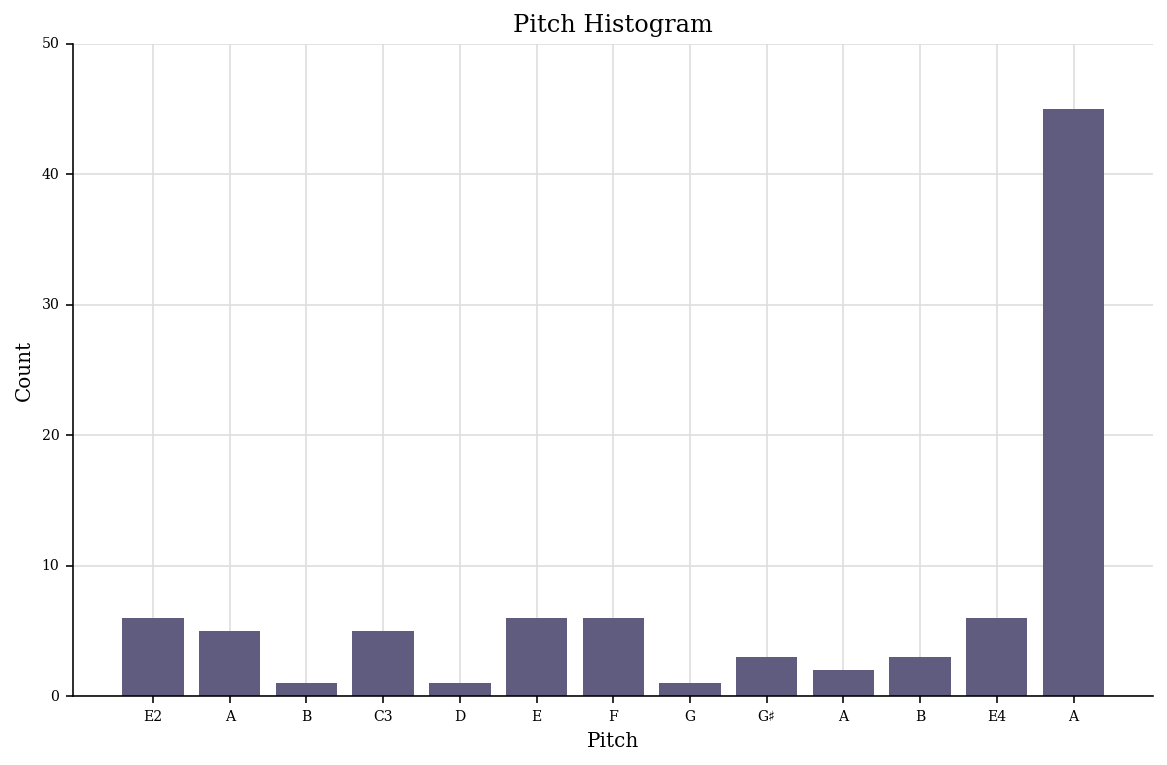

In [89]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x19440f671f0>>

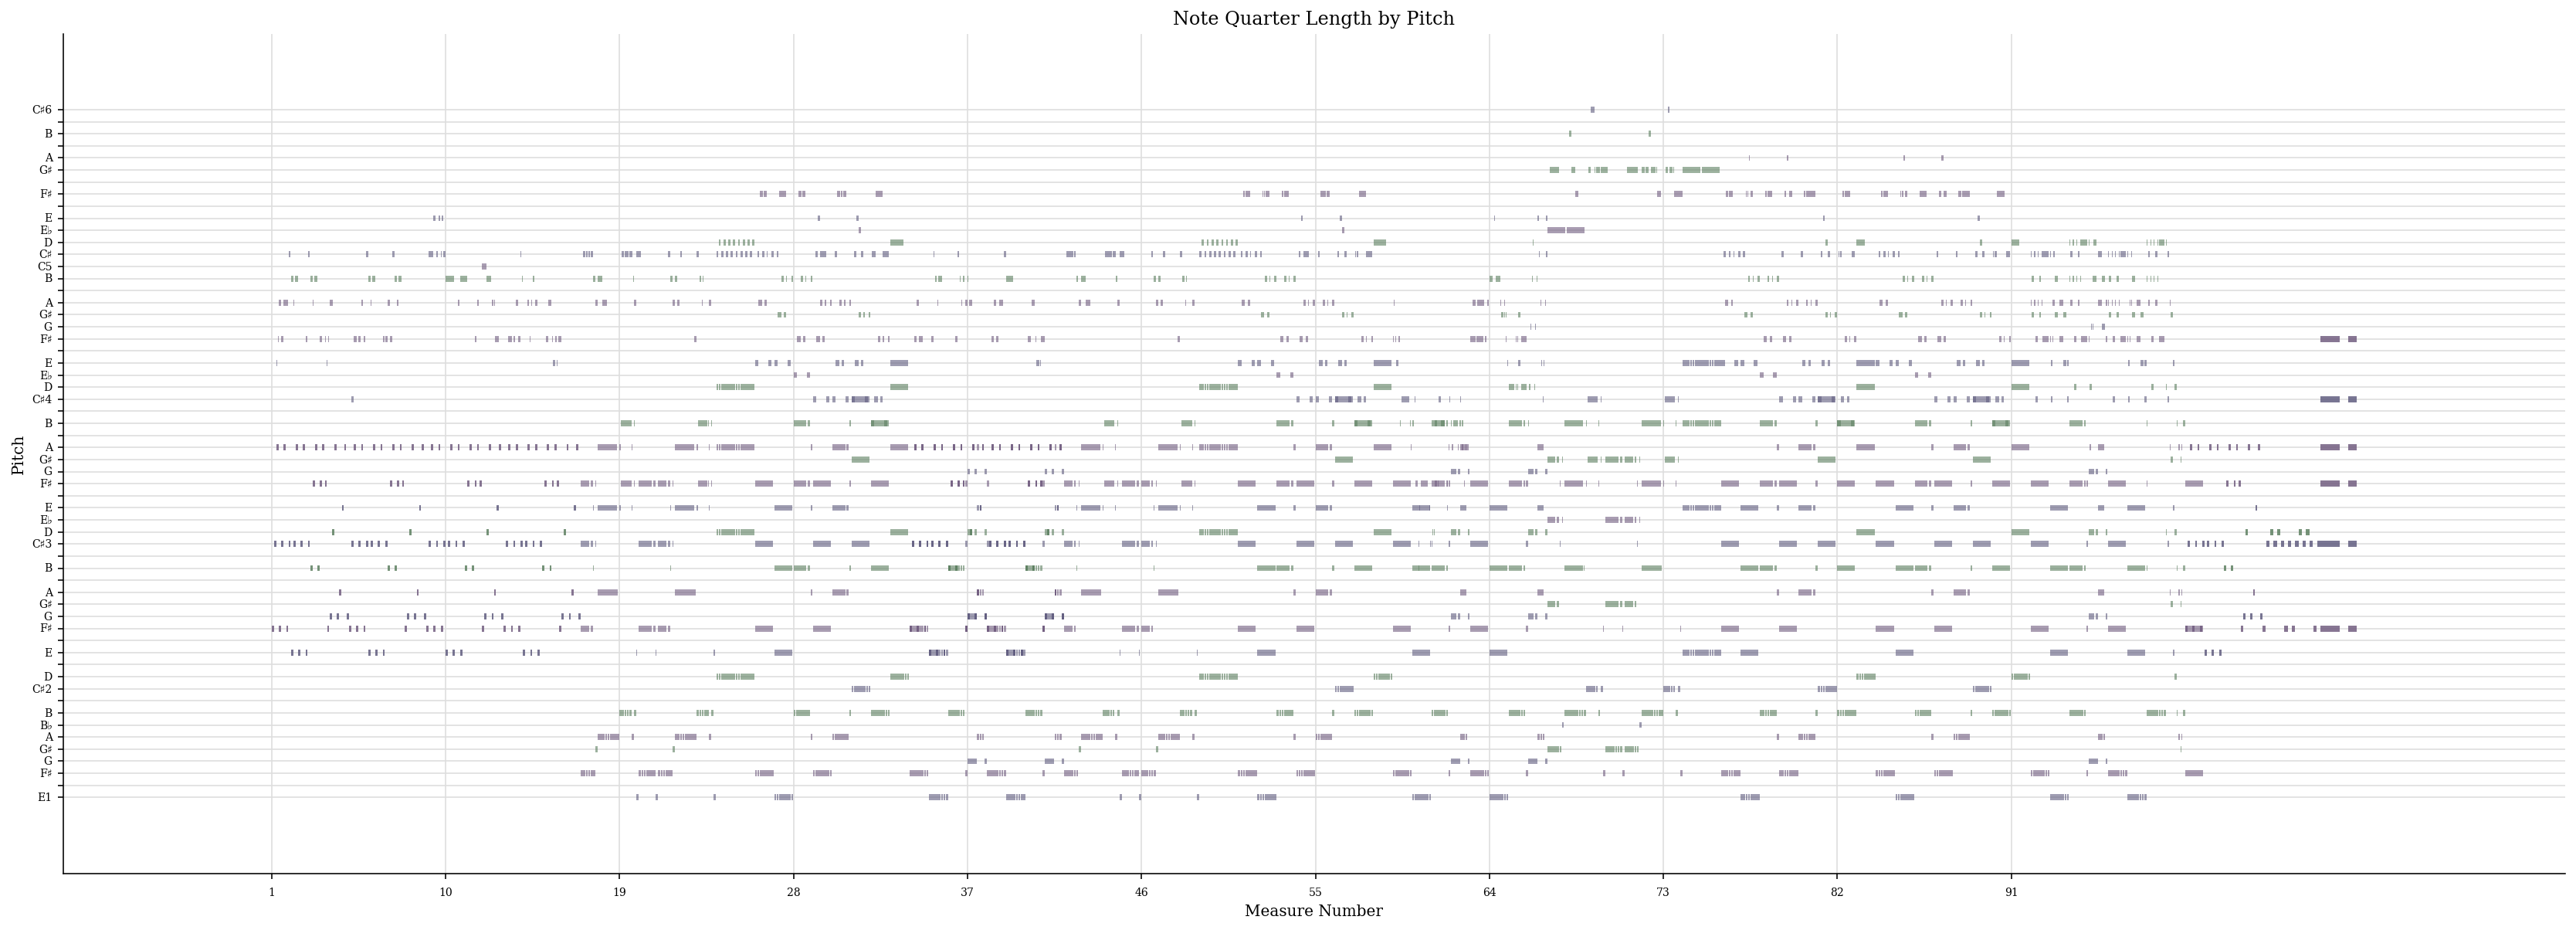

In [90]:
s = converter.parse("datasets\midi_songs3 metal\A Tout Le Monde.mid")
s.plot('pianoroll', figureSize=(30,10))

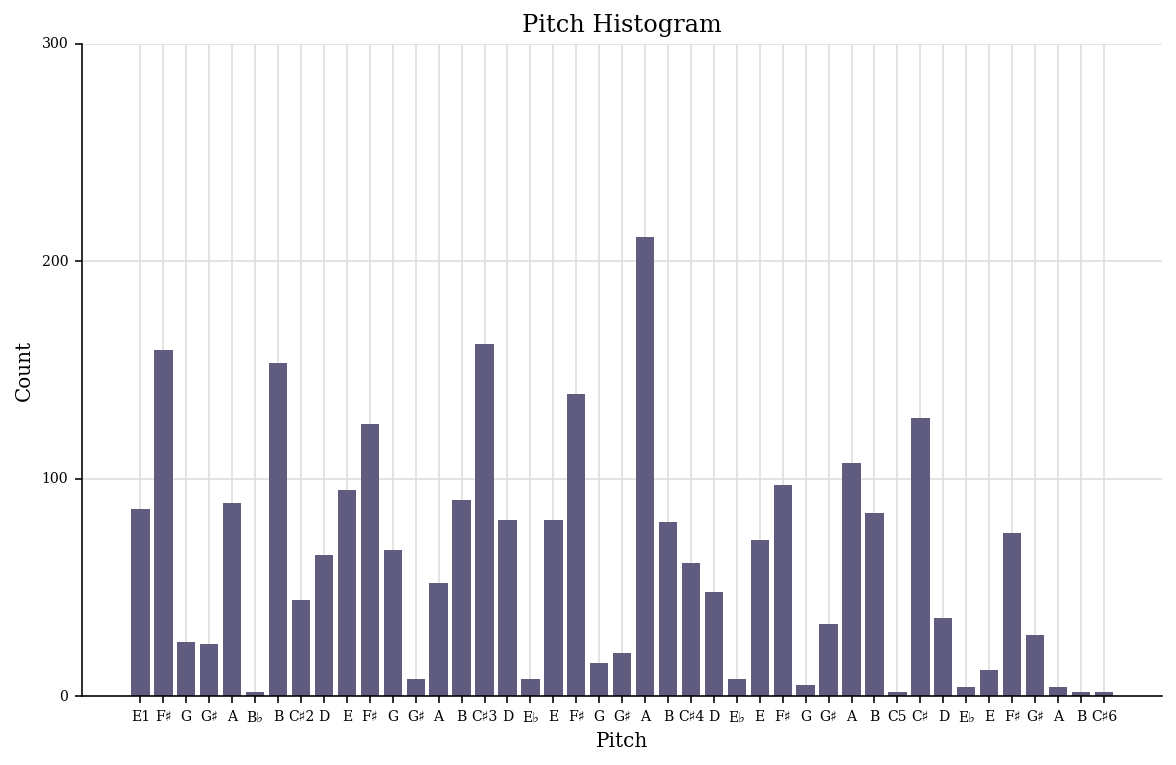

In [91]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x1945f220c70>>

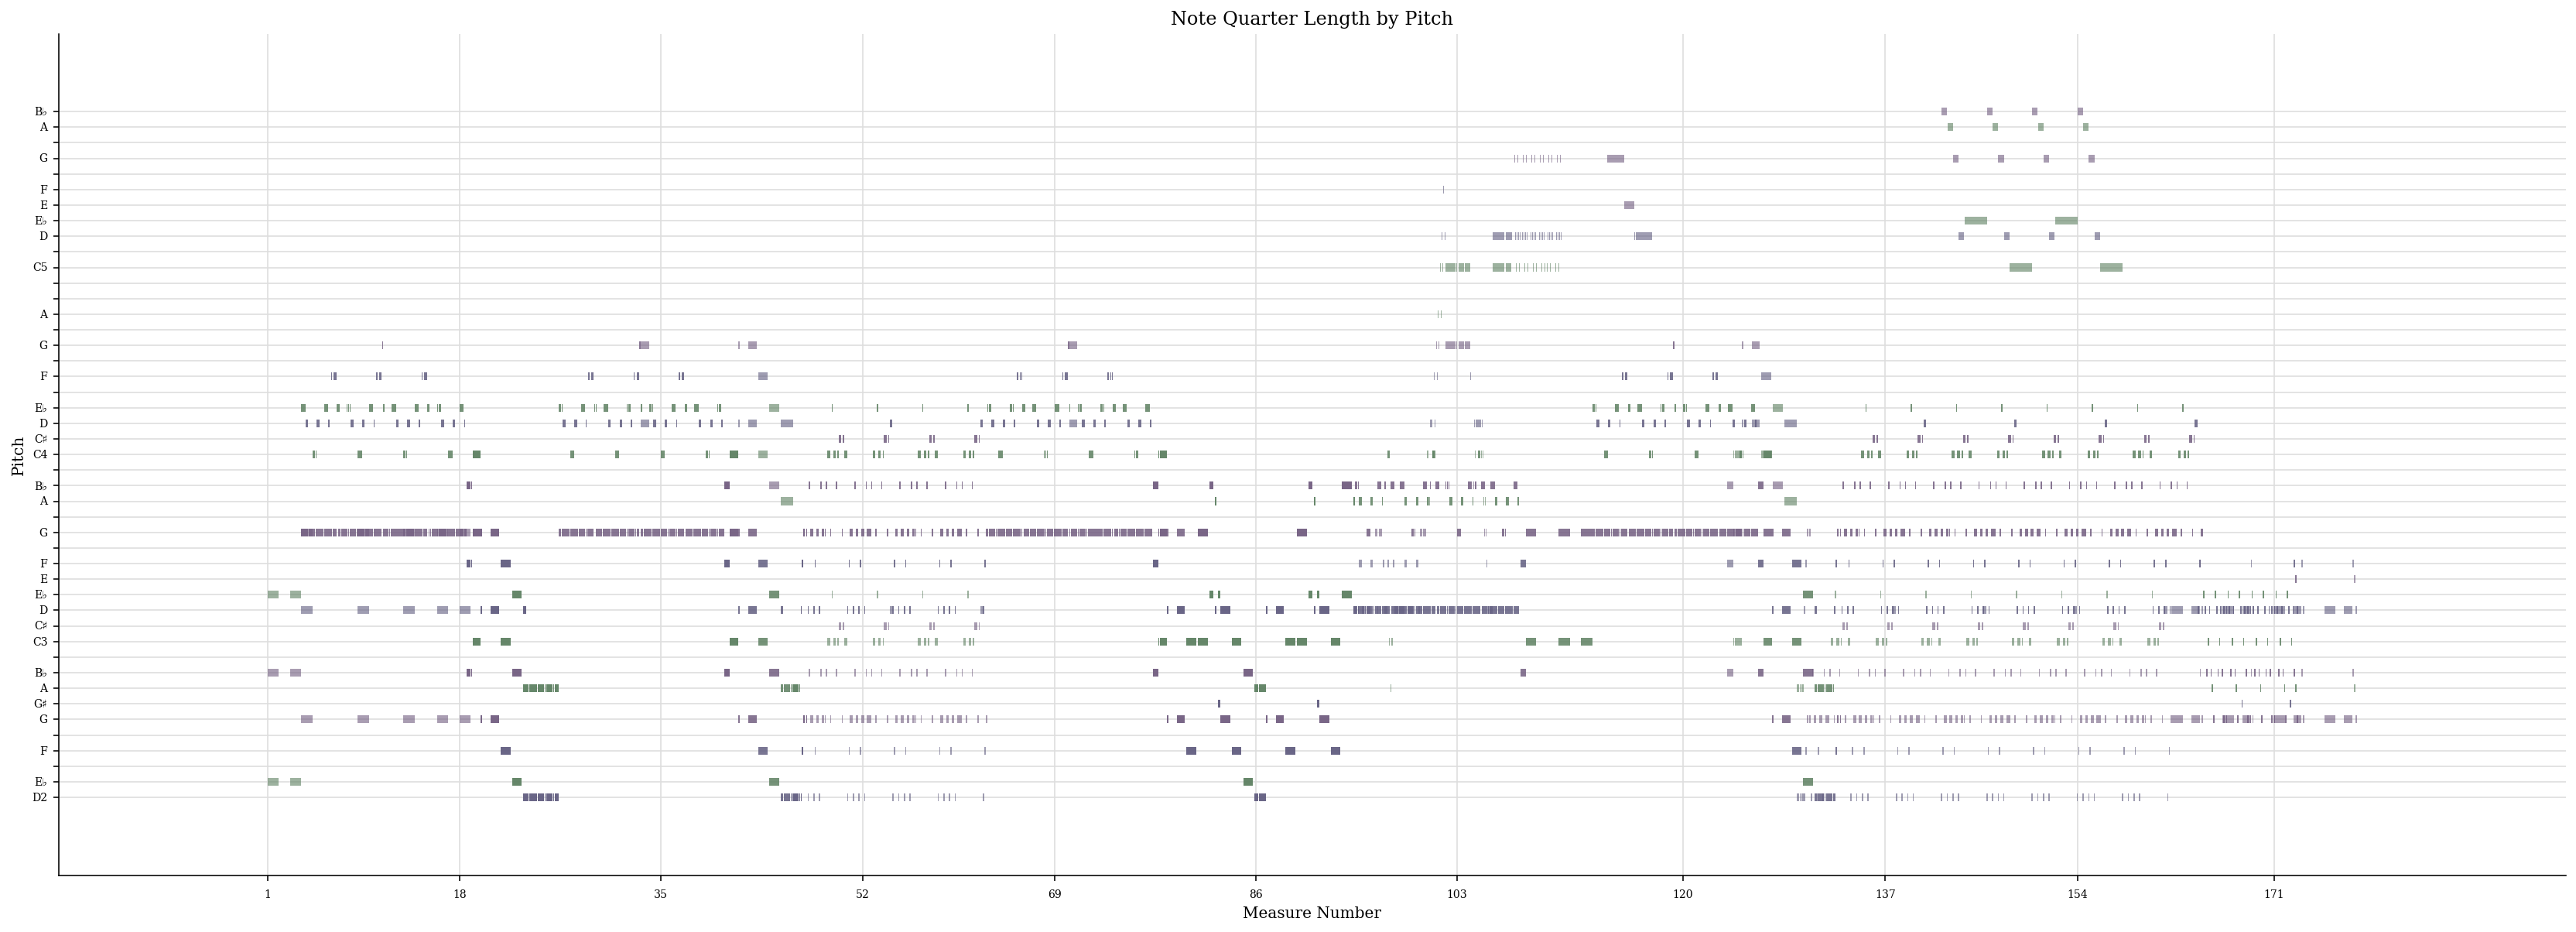

In [92]:
s = converter.parse("datasets\midi_songs3 metal\A Secret Place.mid")
s.plot('pianoroll', figureSize=(30,10))

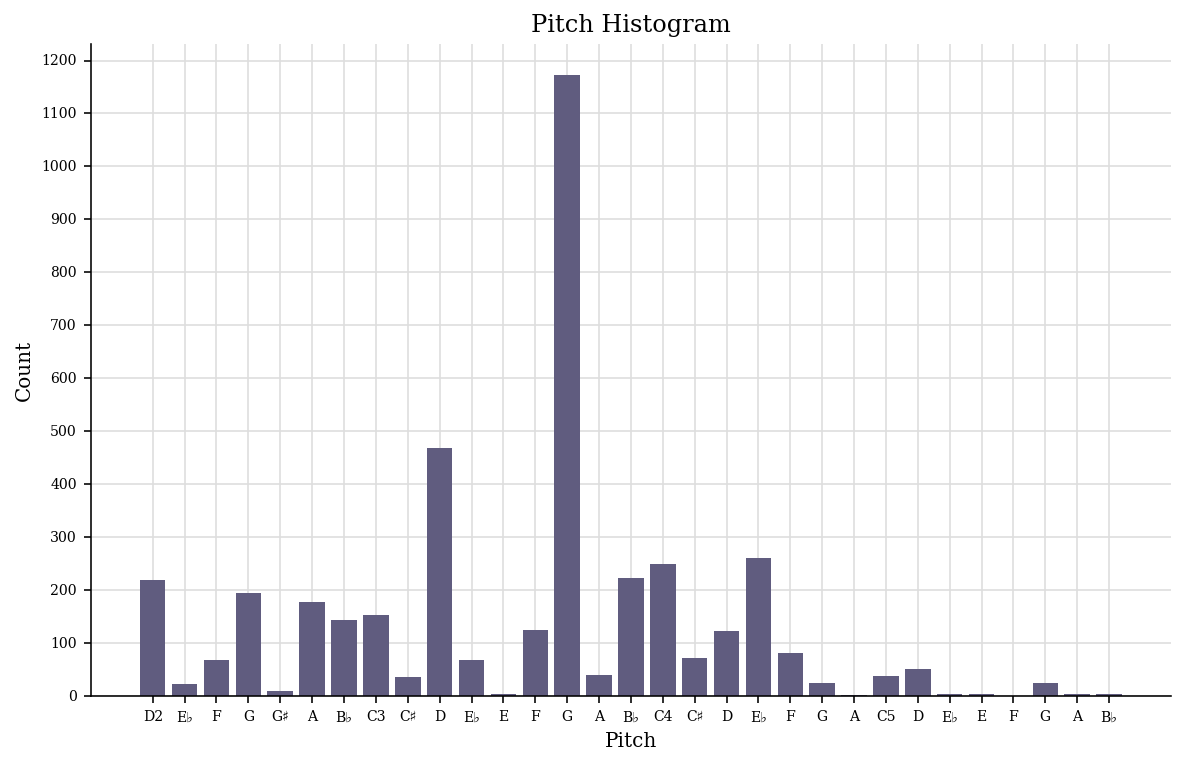

In [93]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x19454f04250>>

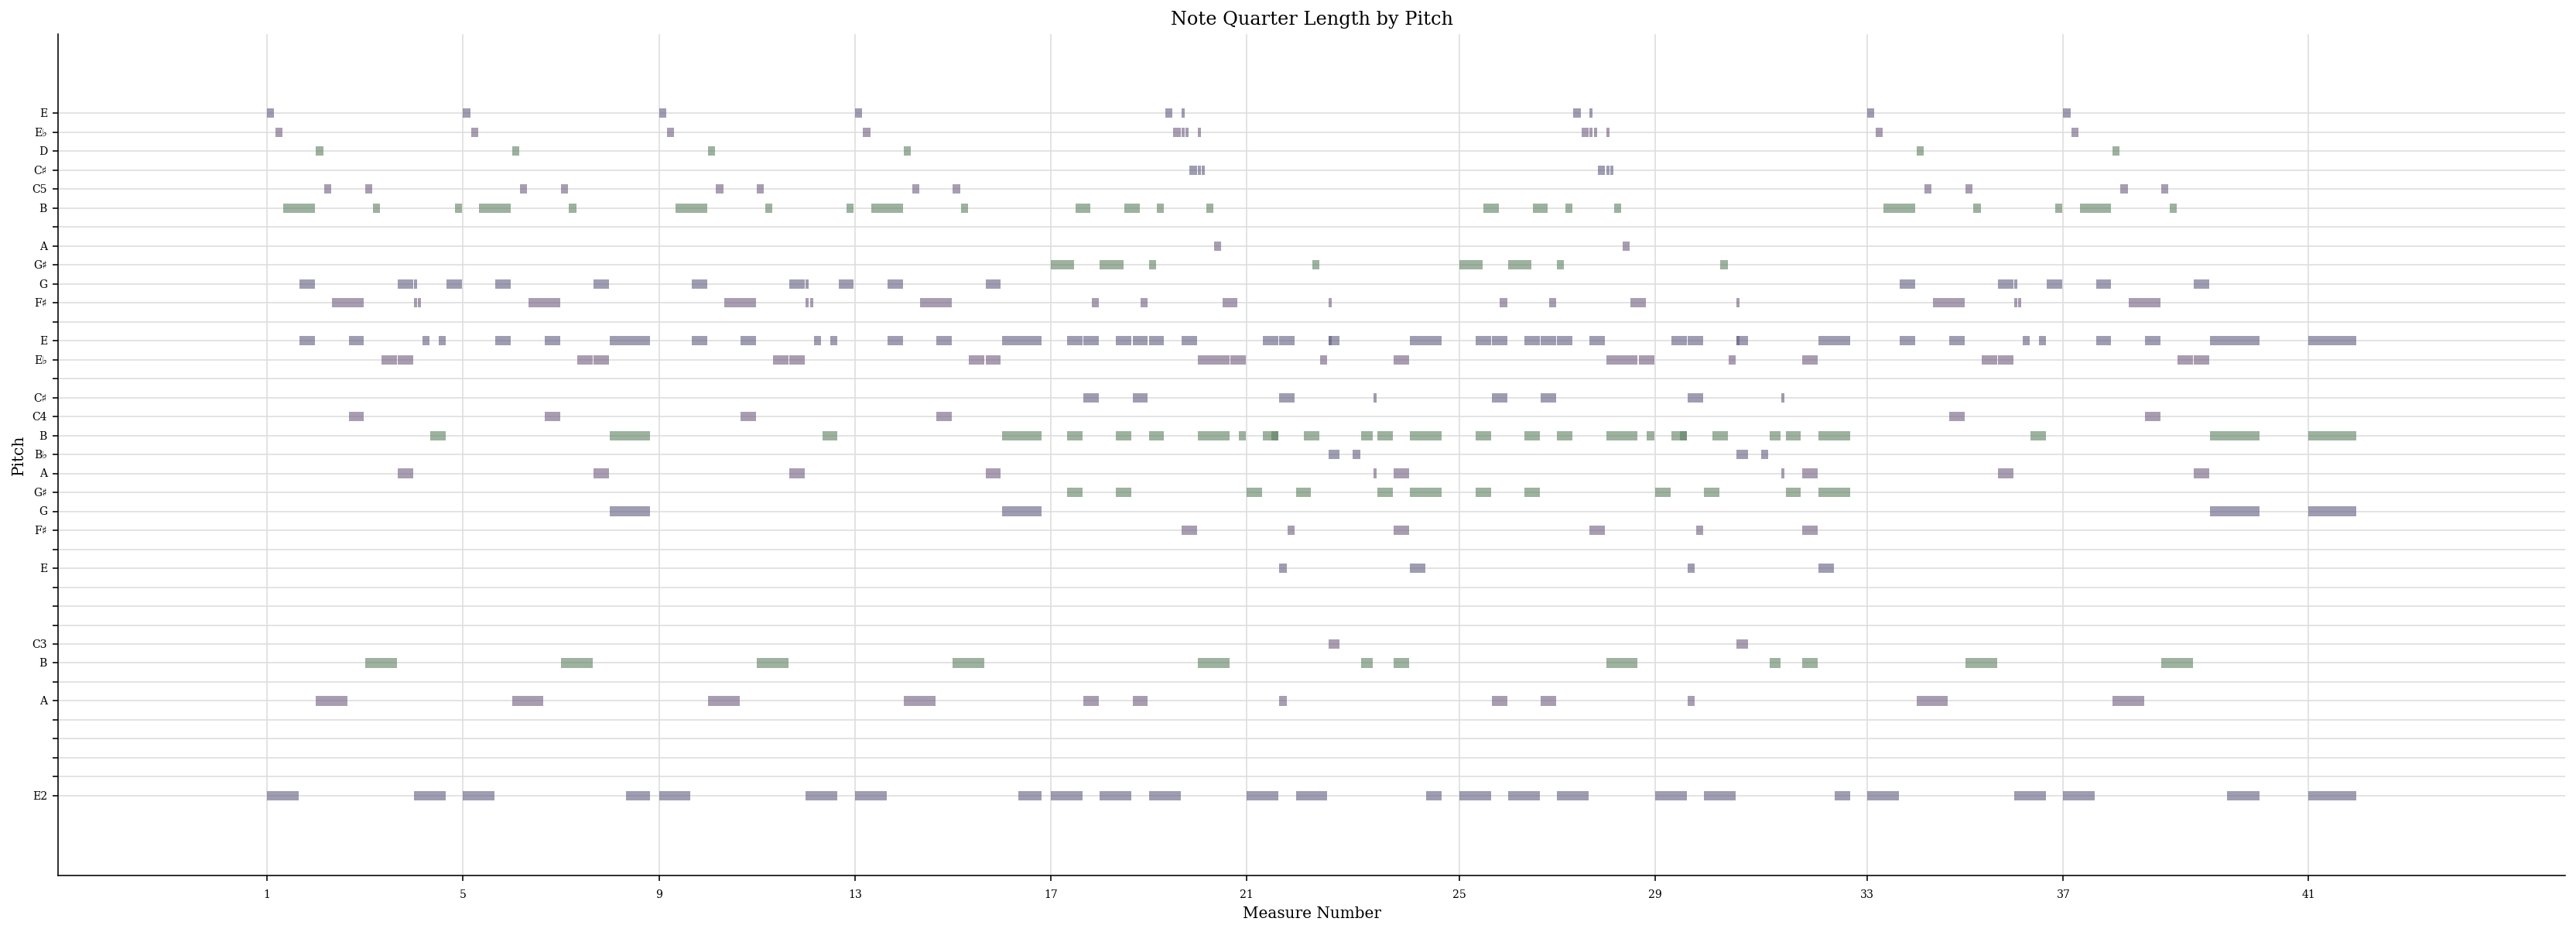

In [94]:
s = converter.parse("datasets\midi_songs5 tarrega\Adelita.mid")
s.plot('pianoroll', figureSize=(30,10))

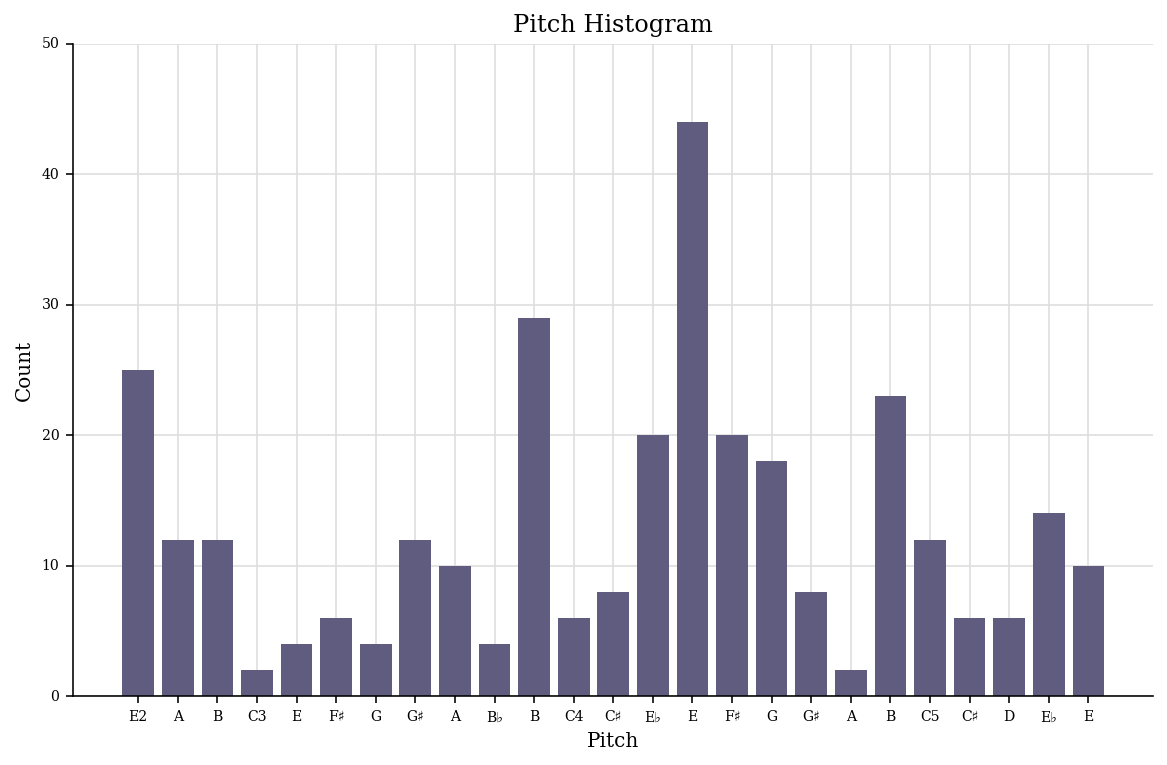

In [95]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x194551ce1c0>>

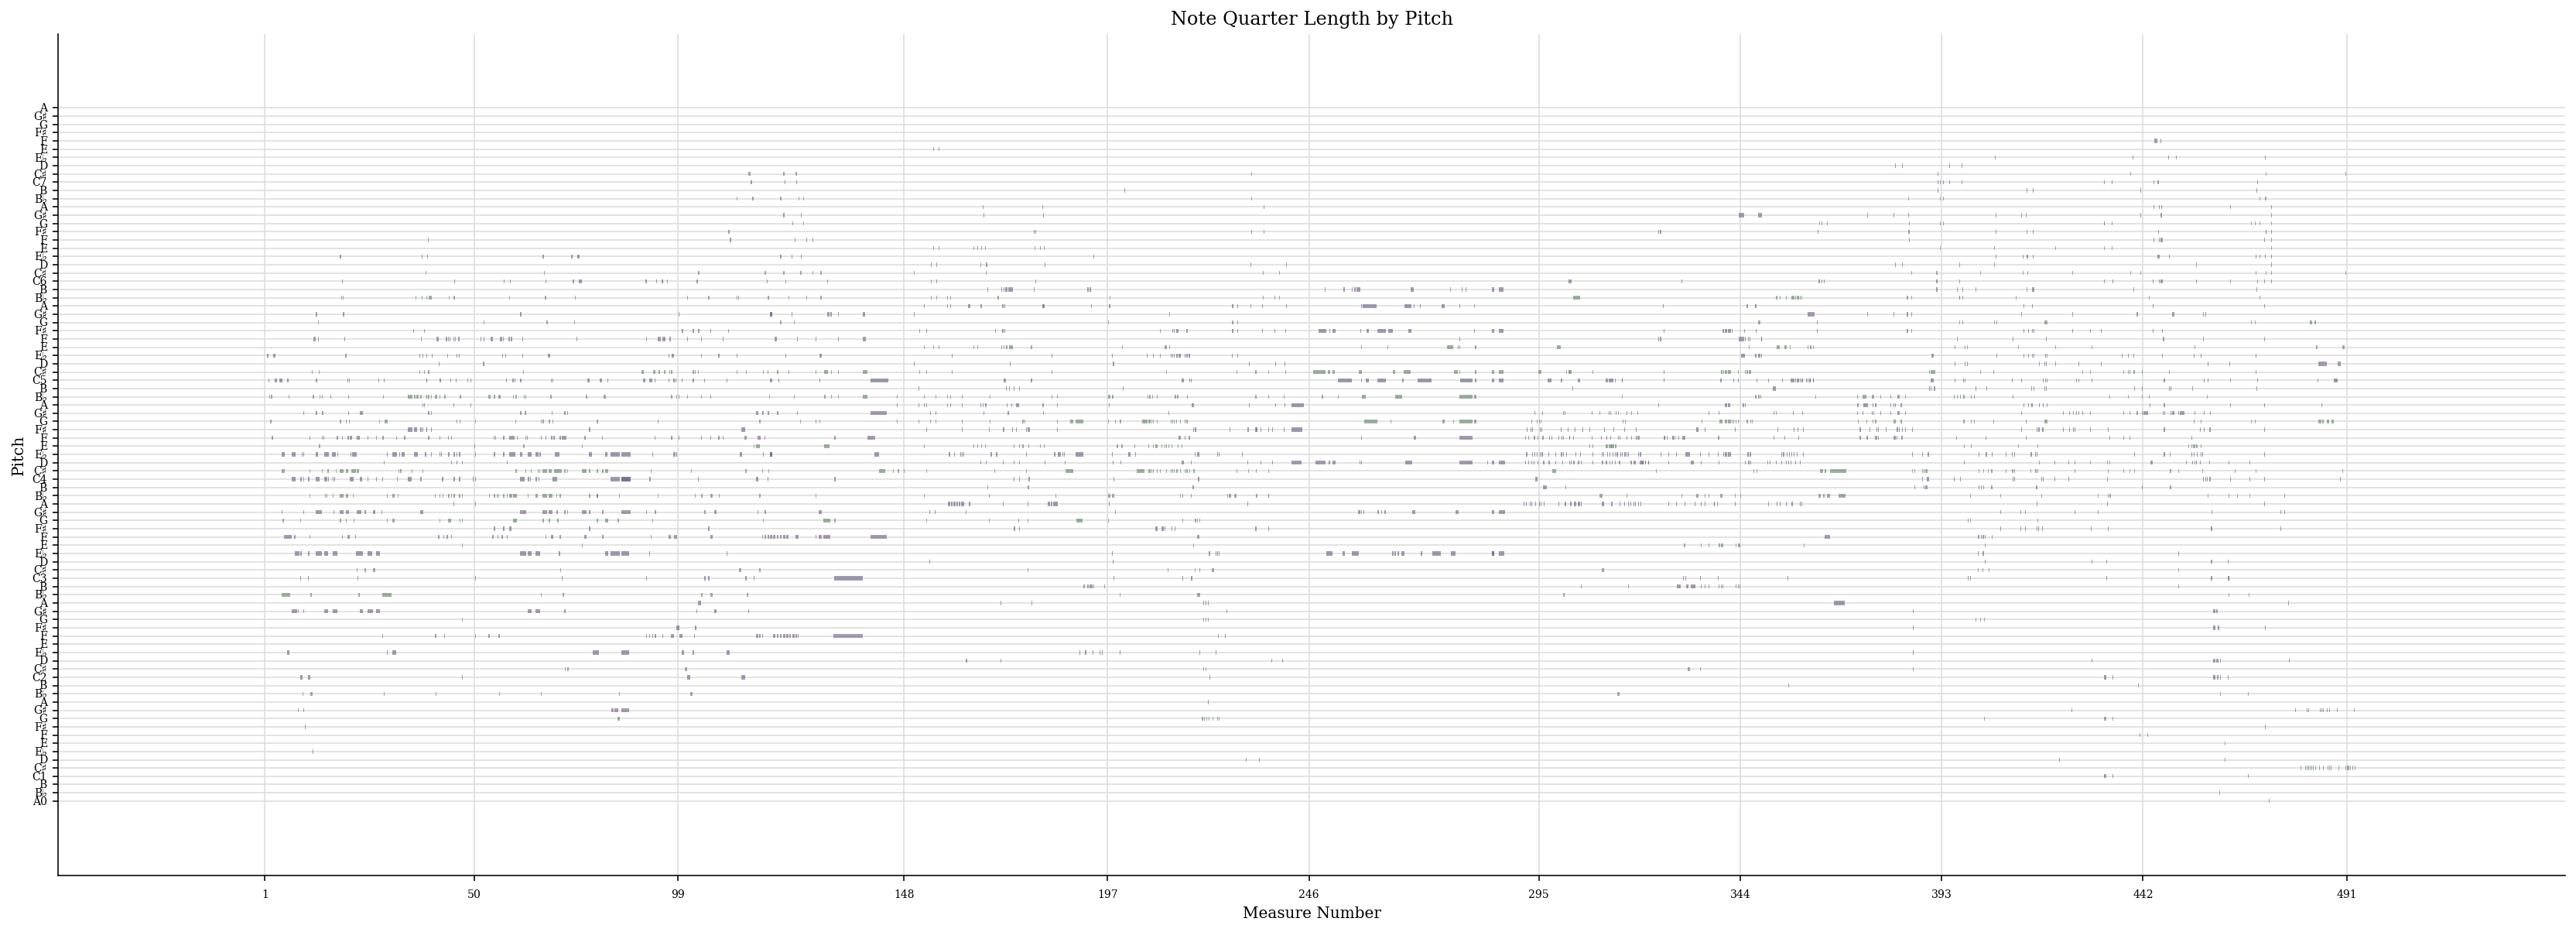

In [96]:
s = converter.parse("datasets\midi_songs maestro\MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_03_Track03_wav.midi")
s.plot('pianoroll', figureSize=(30,10))

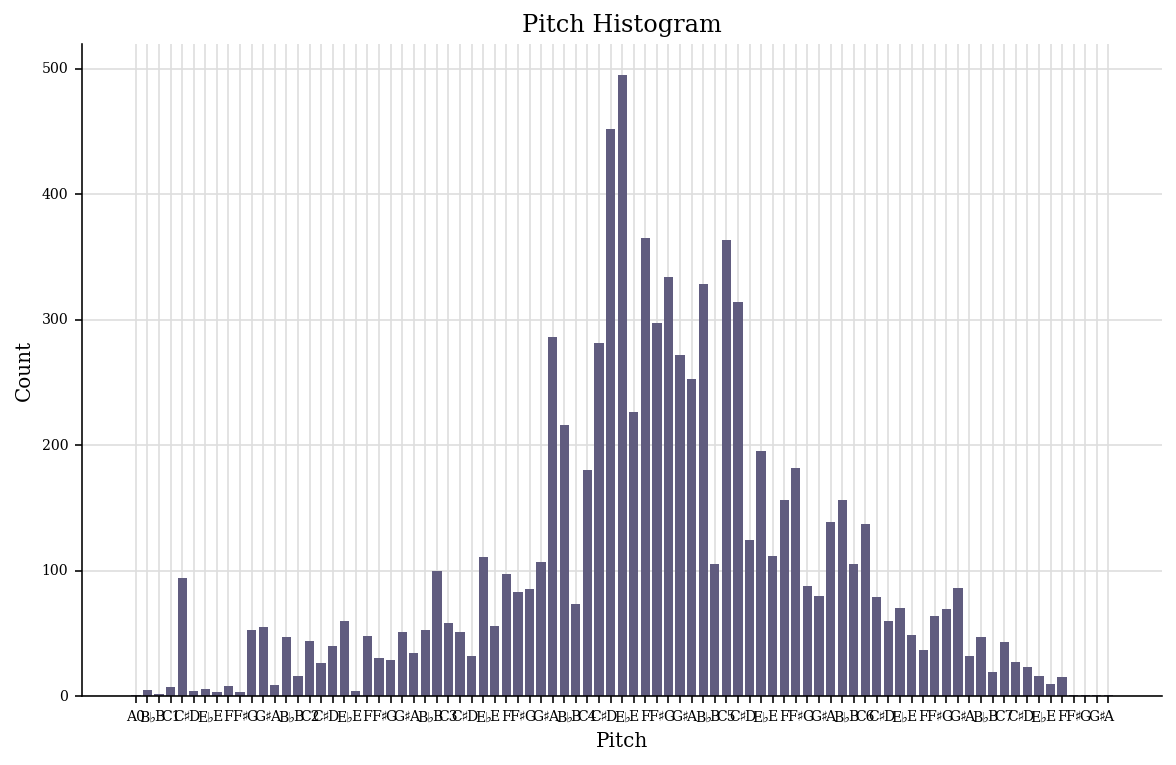

In [97]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

## Setup and Run Model

In [44]:
# Get all the notes and chords from the midi files from the directory and load into array
notes = []

for file in glob.glob("midi_songs6/*.mid"):
    try:
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try:
            n = instrument.partitionByInstrument(midi)
            notes_to_parse = n.parts[0].recurse()
        except: 
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    except:
        print("Error With midi File \n \n")

# save as file for future use
with open('midi_data/notes6', 'wb') as filepath:
    pickle.dump(notes, filepath)


Parsing midi_songs\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_02_Track02_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_04_Track04_wav.midi
Parsing midi_songs\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_

In [ ]:
# Load already existing parsed data
with open('midi_data/notes5', 'rb') as filepath:
    notes = pickle.load(filepath)

In [52]:
# vocab size
n_vocab = len(set(notes))
print(n_vocab)

1593


In [51]:
# make sequence for LSTM
sequence_length = 100

pitchnames = sorted(set(item for item in notes))

# mapping function
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []

# input + output
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
network_input = network_input / float(n_vocab)

network_output = to_categorical(network_output)


In [53]:
# Define Model Structure
model = Sequential()

model.add(CuDNNLSTM(512,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(CuDNNLSTM(512))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 100, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1593)              817209    
_________________________________________________________________
activation_3 (Activation)    (None, 1593)             

In [ ]:
# checkpoint path
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='loss',verbose=0,save_best_only=True,mode='min')
callbacks_list = [checkpoint]

model.fit(network_input, network_output, epochs=5, batch_size=128, callbacks=callbacks_list)


## Generate Midi File

In [ ]:

with open('midi_data/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

pitchnames = sorted(set(item for item in notes))

n_vocab = len(set(notes))

In [ ]:

# mapping function
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

sequence_length = 100
network_input = []
output = []

# input + output
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
normalized_input = normalized_input / float(n_vocab)


In [ ]:
model = Sequential()

model.add(CuDNNLSTM(512,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(CuDNNLSTM(512))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.load_weights('weights.hdf5')

print(model.summary())


In [ ]:
# random starting point
start = numpy.random.randint(0, len(network_input)-1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input[start]
prediction_output = []

n = 500

# generate n number of notes
for note_index in range(n):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    index = numpy.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]


In [ ]:
# Generate the predicted notes into midi data
offset = 0
output_notes = []

for pattern in prediction_output:
    # if it has a . then it is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # else it is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # the time where it is placed in the music piece making each not equal
    offset += 0.5

midi_stream = stream.Stream(output_notes)

# save as midi file
midi_stream.write('midi', fp='test_output.mid')


## Output Visualization

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x19442841880>>

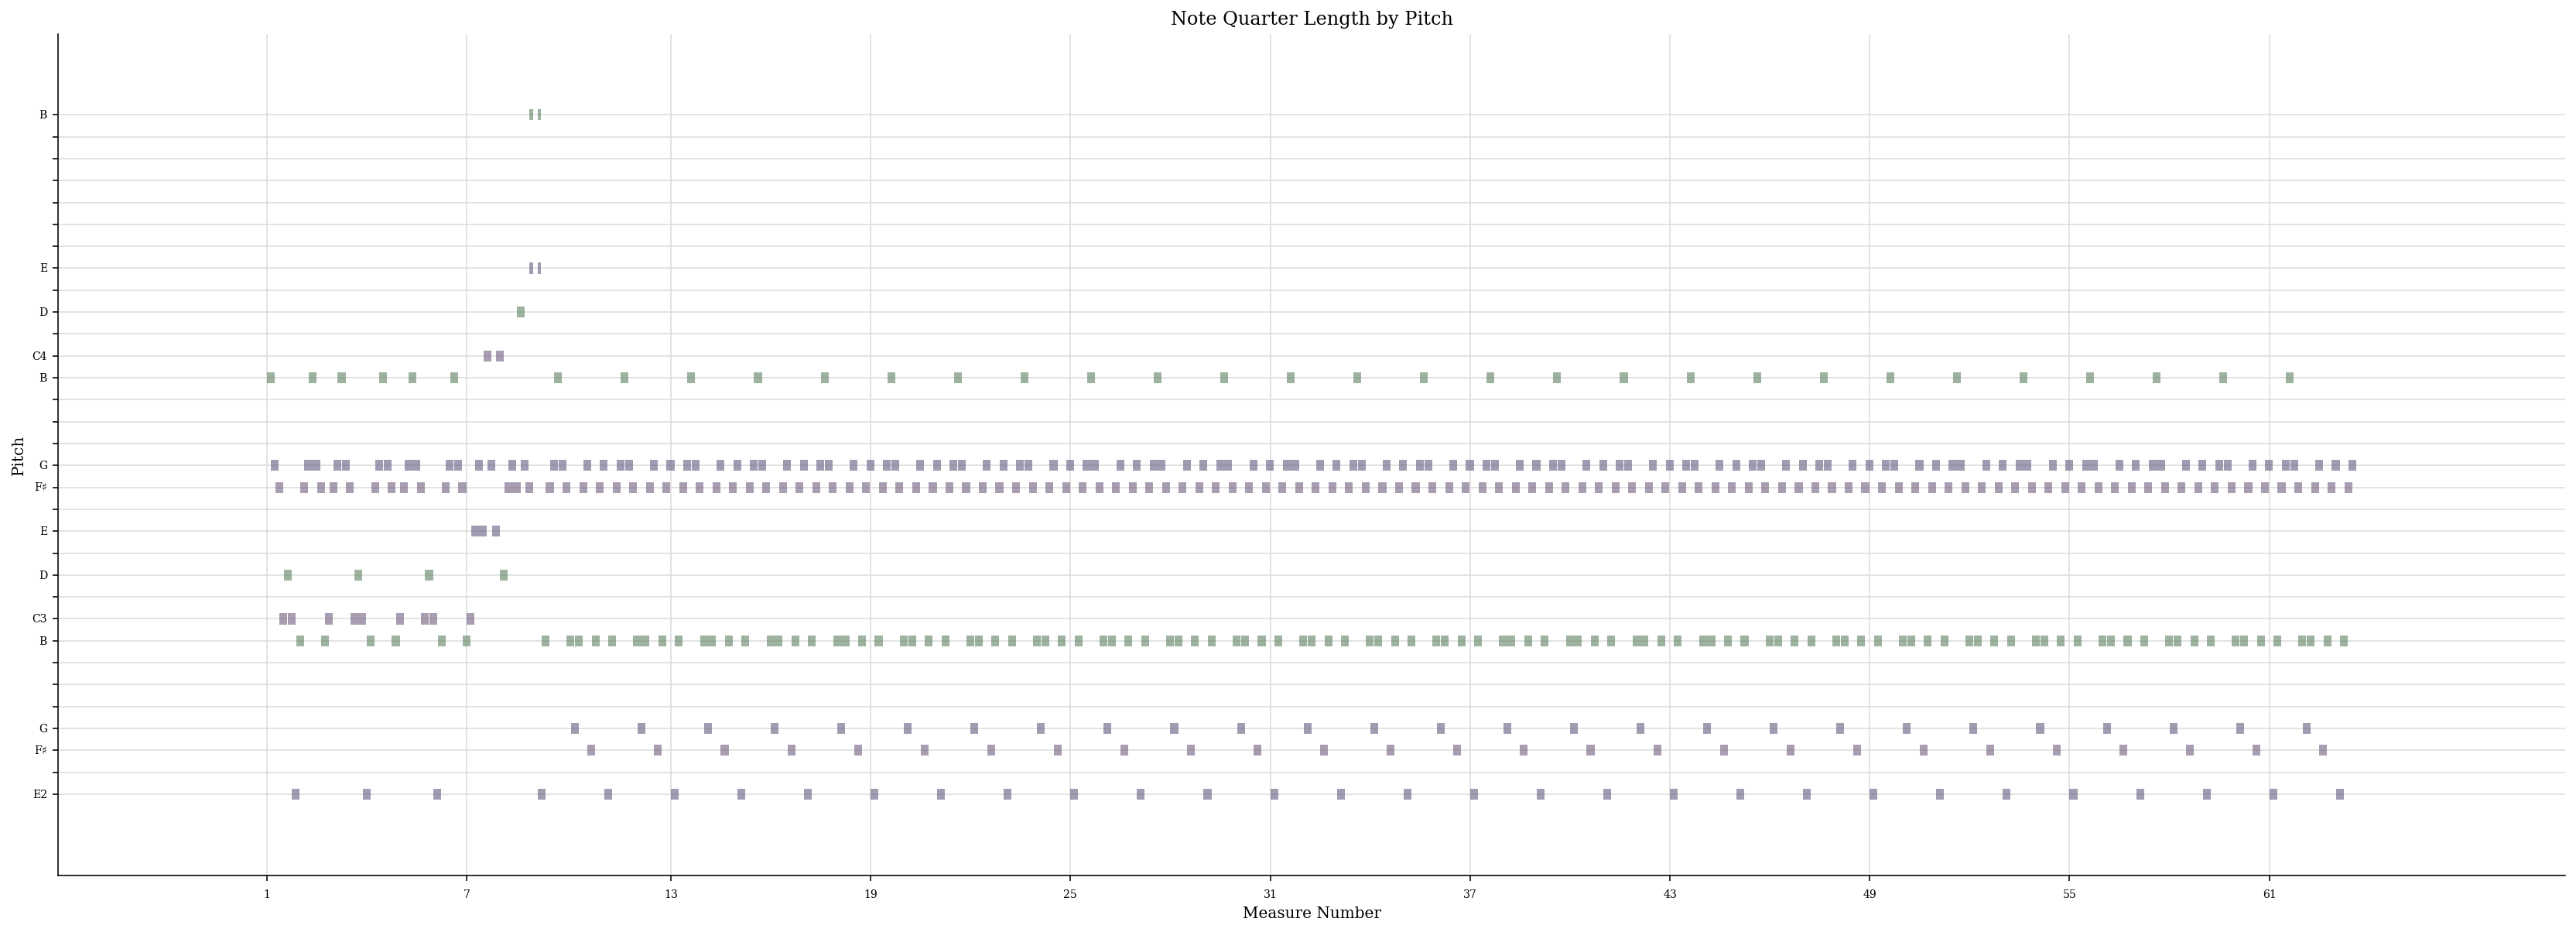

In [79]:
s = converter.parse("output/test_output6(Electric Model49).mid")
s.plot('pianoroll', figureSize=(30,10))


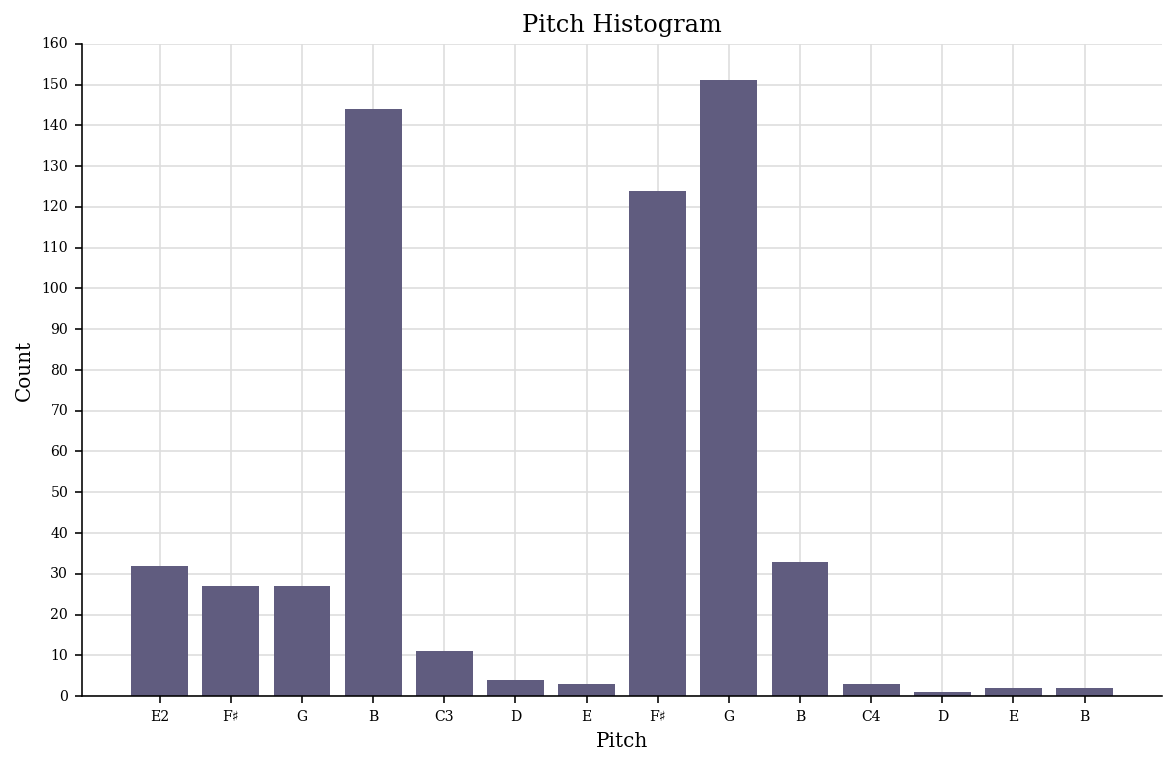

In [80]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x1943f25dc70>>

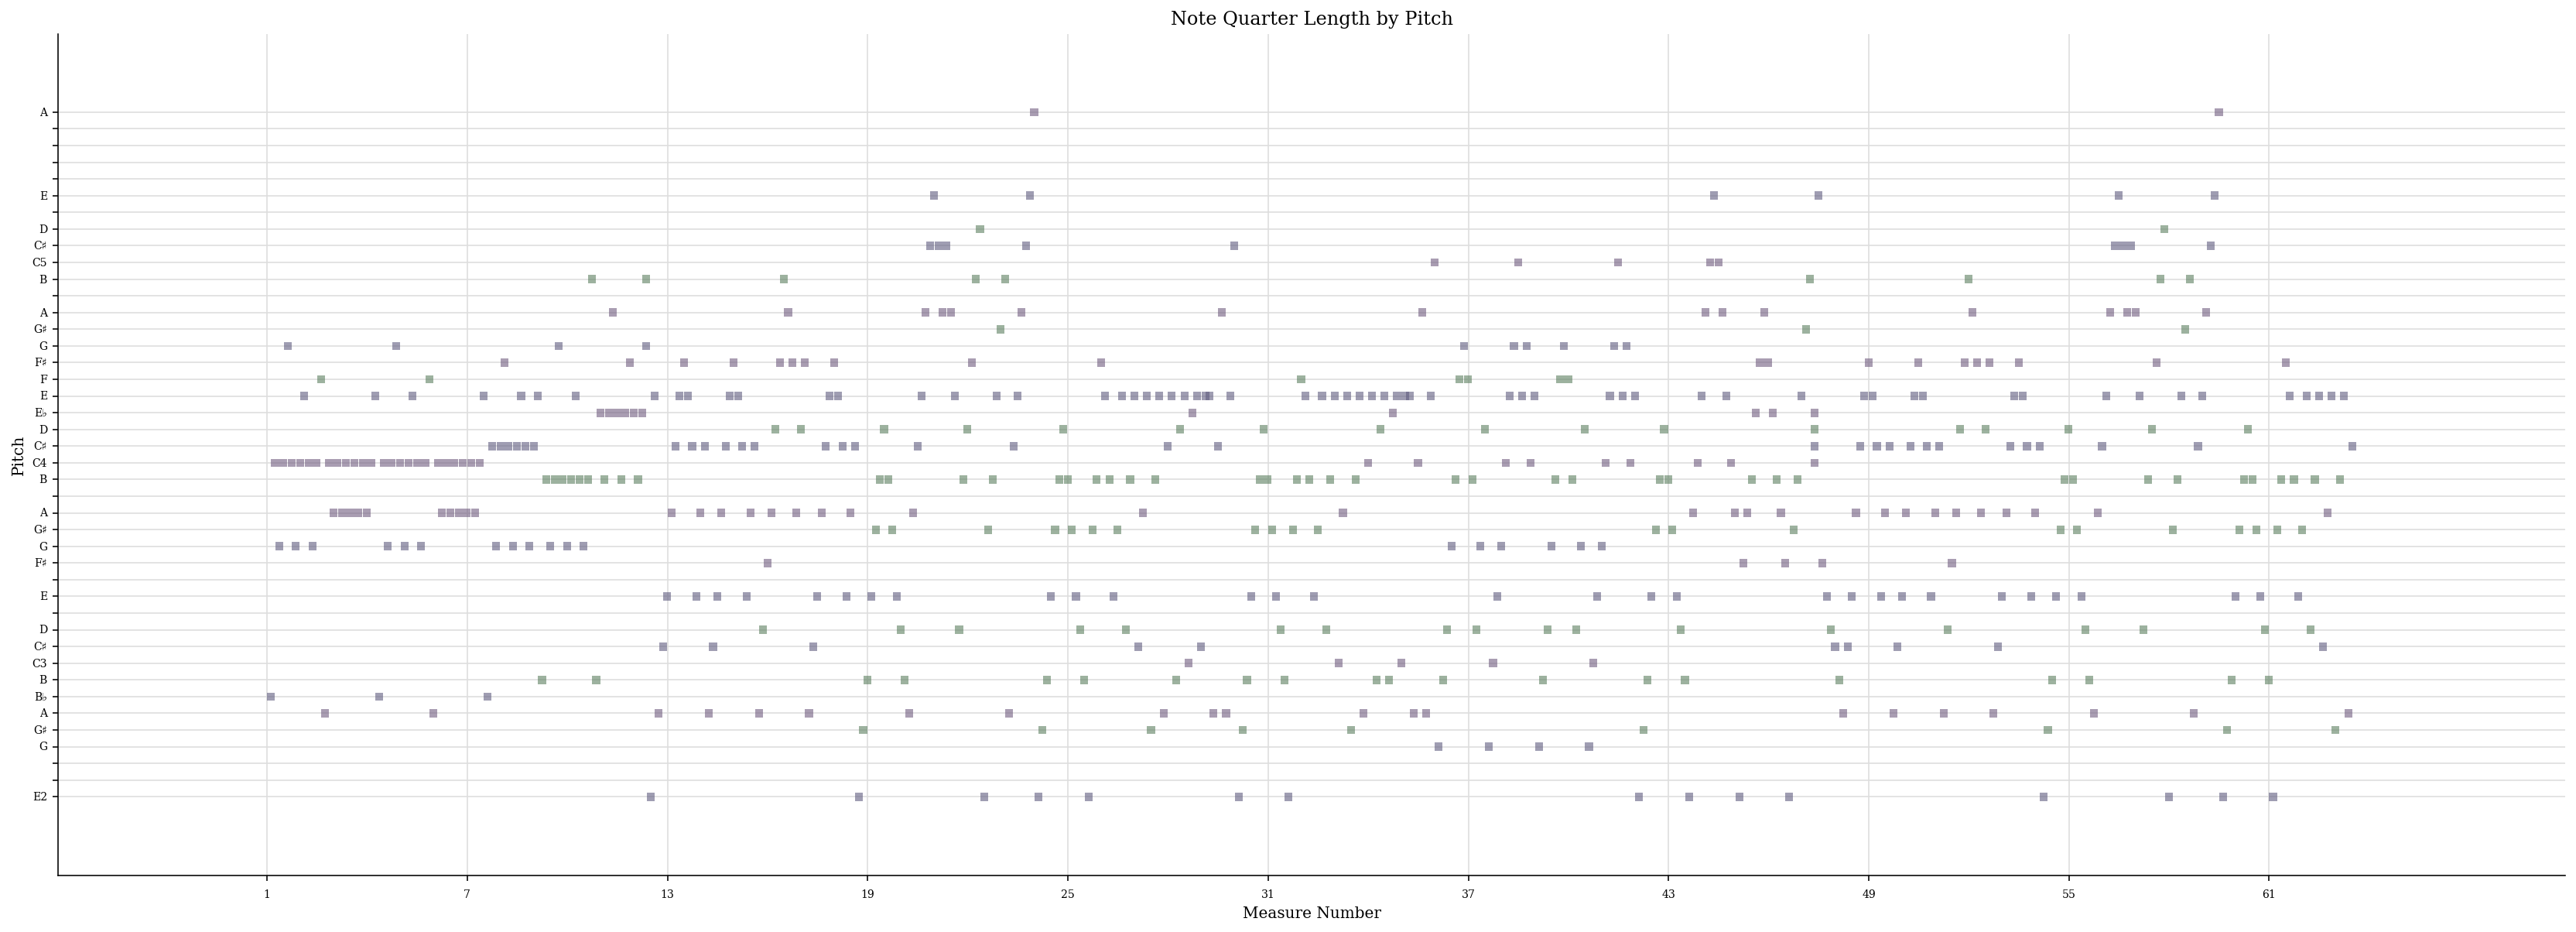

In [81]:
s = converter.parse("output/test_output5(Guitar).mid")
s.plot('pianoroll', figureSize=(30,10))


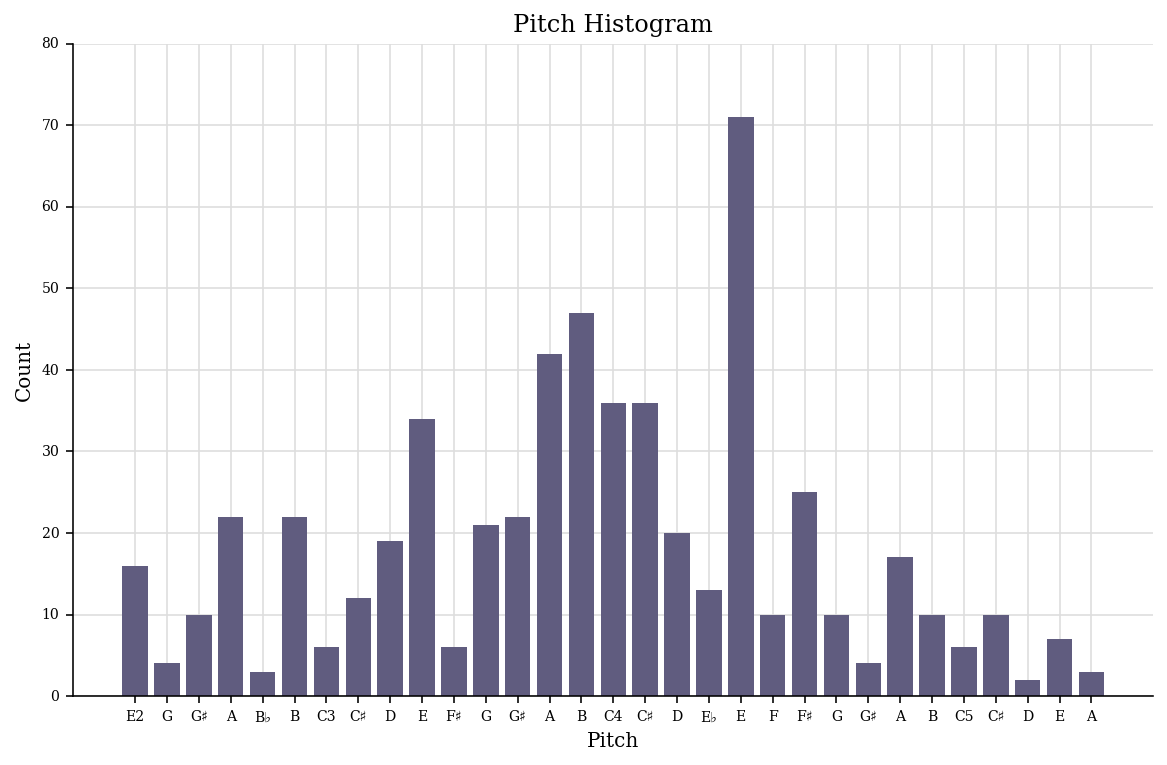

In [82]:
p = graph.plot.HistogramPitchSpace(s)
p.run()

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x1945f6ff1f0>>

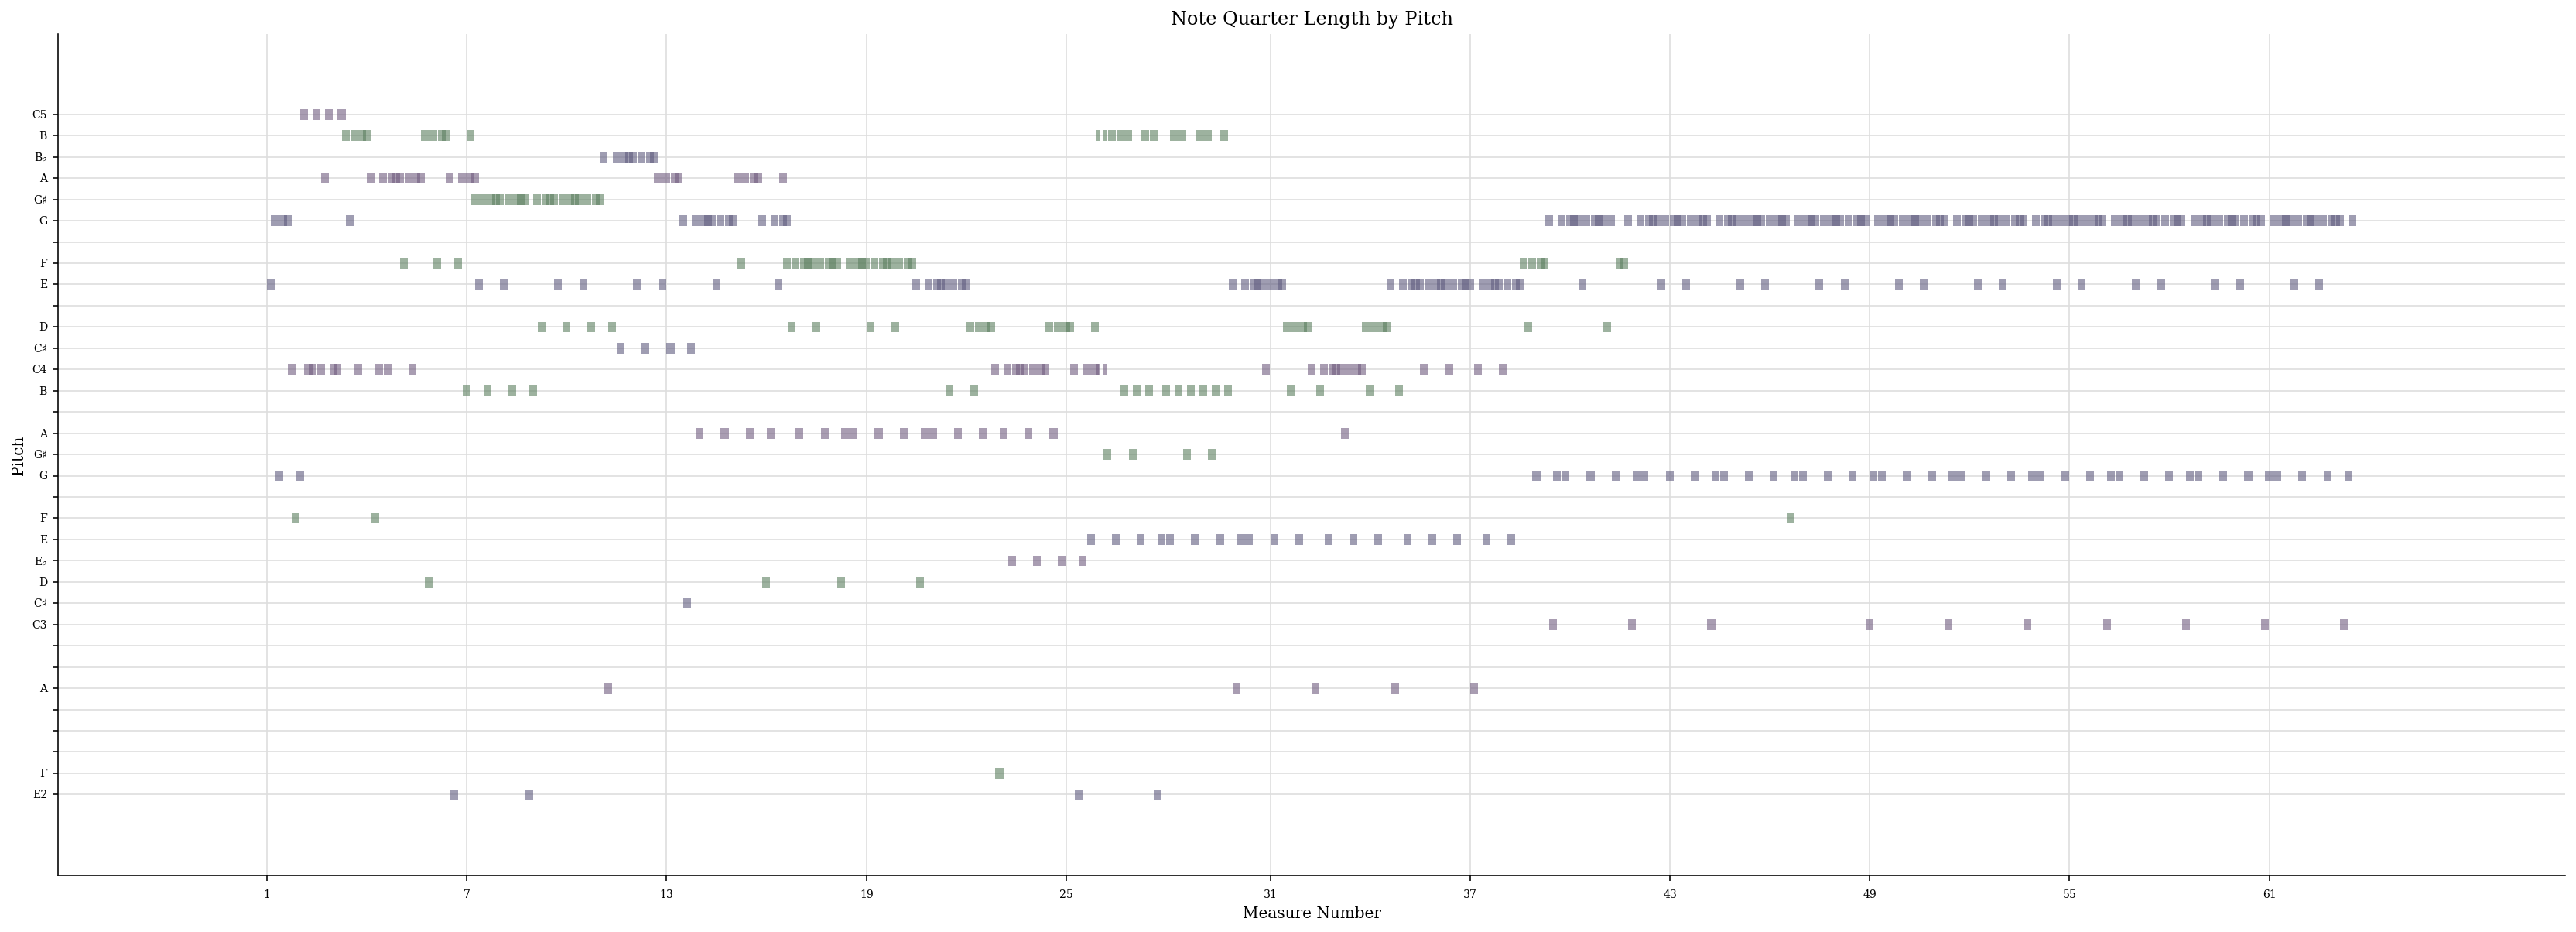

In [83]:
s = converter.parse("output/test_output(Tarrega model 67).mid")
s.plot('pianoroll', figureSize=(30,10))


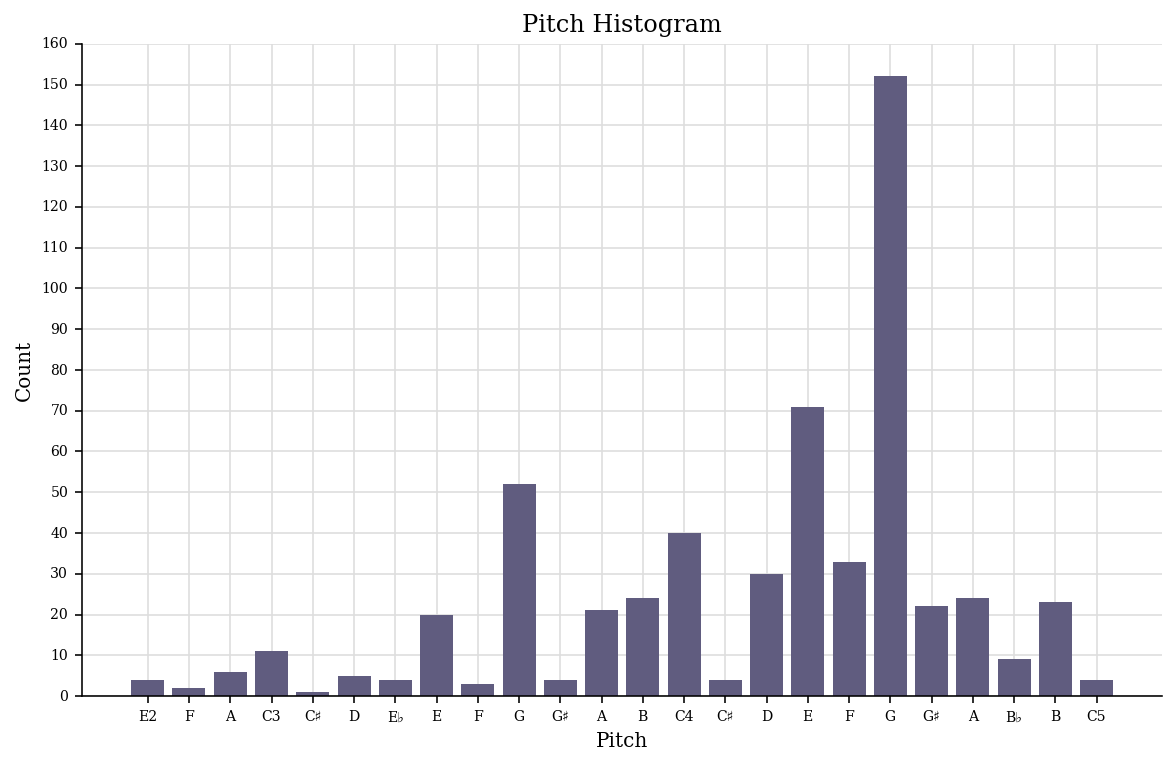

In [84]:
p = graph.plot.HistogramPitchSpace(s)
p.run()